In [29]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import kagglehub
import matplotlib.pyplot as plt

In [30]:
# Descargar y cargar el dataset desde Kaggle
path = kagglehub.dataset_download("mnassrib/jena-climate")
df = pd.read_csv(f"{path}/jena_climate_2009_2016.csv")
df = df[['T (degC)']]  # Usamos solo la temperatura

In [31]:
# Normalización de los datos
data = df.values.astype('float32')
mean = data.mean()
std = data.std()
data = (data - mean) / std

In [35]:
def create_dataset(data, start_index, end_index, window_size, batch_size):
    return timeseries_dataset_from_array(
        data[start_index:end_index],
        data[start_index + window_size:end_index + window_size],
        sequence_length=window_size,
        batch_size=batch_size)

# Parámetros
n = len(data)
window_size = 24
batch_size = 32

# Crear los datasets sin perder datos
train_dataset = create_dataset(data, 0, int(n * 0.8), window_size, batch_size)
val_dataset = create_dataset(data, int(n * 0.8), int(n * 0.9), window_size, batch_size)
test_dataset = create_dataset(data, int(n * 0.9), n, window_size, batch_size)

# Ajustar las dimensiones de cada dataset
train_dataset = train_dataset.map(lambda x, y: (tf.reshape(x, (tf.shape(x)[0], window_size, 1)), y))
val_dataset = val_dataset.map(lambda x, y: (tf.reshape(x, (tf.shape(x)[0], window_size, 1)), y))
test_dataset = test_dataset.map(lambda x, y: (tf.reshape(x, (tf.shape(x)[0], window_size, 1)), y))



In [36]:
# Definir el modelo mejorado
model = Sequential([
    Flatten(input_shape=(window_size, 1)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Salida para regresión
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [37]:
# Usar EarlyStopping para evitar sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset,
                    callbacks=[early_stopping])

Epoch 1/10
10514/10514 ━━━━━━━━━━━━━━━━━━━━ 71s 7ms/step - loss: 0.0335 - mae: 0.1186 - val_loss: 0.0087 - val_mae: 0.0691
Epoch 2/10
10514/10514 ━━━━━━━━━━━━━━━━━━━━ 76s 7ms/step - loss: 0.0187 - mae: 0.0937 - val_loss: 0.0063 - val_mae: 0.0597
Epoch 3/10
10514/10514 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - loss: 0.0178 - mae: 0.0918 - val_loss: 0.0069 - val_mae: 0.0631
Epoch 4/10
10514/10514 ━━━━━━━━━━━━━━━━━━━━ 80s 7ms/step - loss: 0.0174 - mae: 0.0910 - val_loss: 0.0096 - val_mae: 0.0676
Epoch 5/10
10514/10514 ━━━━━━━━━━━━━━━━━━━━ 76s 7ms/step - loss: 0.0163 - mae: 0.0879 - val_loss: 0.0051 - val_mae: 0.0530
Epoch 6/10
10514/10514 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - loss: 0.0173 - mae: 0.0894 - val_loss: 0.0146 - val_mae: 0.0891
Epoch 7/10
10514/10514 ━━━━━━━━━━━━━━━━━━━━ 71s 7ms/step - loss: 0.0169 - mae: 0.0895 - val_loss: 0.0059 - val_mae: 0.0586
Epoch 8/10
10514/10514 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - loss: 0.0164 - mae: 0.0881 - val_loss: 0.0109 - val_mae: 0.0751


1314/1314 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0041 - mae: 0.0479
MAE en el conjunto de prueba: 0.05298597365617752
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


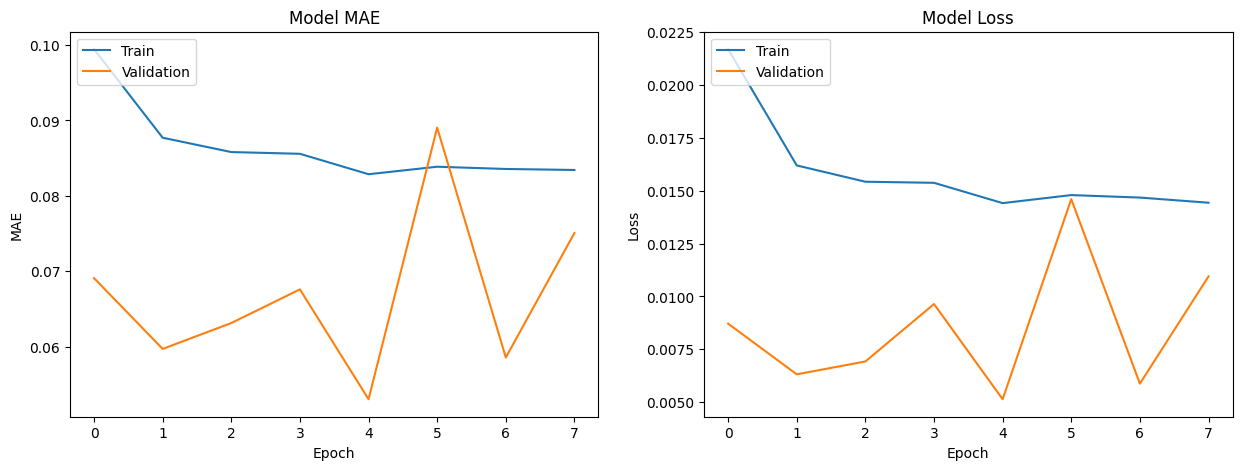

In [39]:
# Evaluar el modelo en el dataset de prueba
loss, mae = model.evaluate(test_dataset)
print(f'MAE en el conjunto de prueba: {mae}')

def plotmodelhistory(history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Graficar el MAE (Mean Absolute Error)
    axs[0].plot(history.history['mae'])
    axs[0].plot(history.history['val_mae'])
    axs[0].set_title('Model MAE')
    axs[0].set_ylabel('MAE')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    # Graficar la pérdida (Loss)
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Imprimir las claves del historial para verificar que todo esté bien
print(history.history.keys())

# Llamar a la función para graficar el historial del modelo
plotmodelhistory(history)

# ANALISIS

La estructura de los datos de serie temporal tiene un impacto significativo en el modelo, ya que se emplearon ventanas para dividir la secuencia en subsecuencias más pequeñas que faciliten el aprendizaje. Esta aproximación permite capturar la dependencia entre los valores pasados y las predicciones futuras. Sin embargo, una estructura temporal fuerte también implica que los datos no deben mezclarse aleatoriamente entre entrenamiento, validación y prueba para evitar una fuga de información temporal que podría distorsionar los resultados del modelo.

## Análisis de Rendimiento del Modelo
Con base en los datos obtenidos en el entrenamiento, se observa una evolución tanto en la pérdida (loss) como en el MAE (Mean Absolute Error) a lo largo de las 10 épocas de entrenamiento.
El modelo logra reducir progresivamente la pérdida y el MAE en el conjunto de entrenamiento, lo que indica que fue capaz de aprender patrones significativos en los datos.
Sin embargo, los resultados de validación muestran algunas fluctuaciones en las métricas, lo que sugiere que el modelo podría estar experimentando cierta dificultad para generalizar correctamente.

## Conjunto de entrenamiento:

La pérdida disminuye de 0.0335 en la primera época a 0.0164 en la octava época.
El MAE también se reduce consistentemente de 0.1186 a 0.0831.

## Conjunto de validación:

La pérdida de validación (val_loss) disminuye inicialmente, pero fluctúa de forma significativa, y su valor final es 0.0109.
El MAE de validación comienza en 0.0691, muestra algunas subidas (por ejemplo, a 0.0891) y finalmente desciende a 0.0751 en la última época.

Estas oscilaciones en el error pueden ser resultado de cambios en la estructura temporal de los datos o de la insuficiencia del modelo para capturar todos los patrones relevantes en los datos más recientes.

Se puede decir entonces que el modelo tiene overfitting ya que no logra generalizar.